<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Test/Variational_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Variational Inference on the Test Data

## Importing Packages

In [22]:
import matplotlib.pyplot as plt

In [23]:
%matplotlib inline

In [24]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax
from functools import partial
import jax

In [25]:
from jax.config import config
config.update("jax_enable_x64", True)

## Load Test Data

In [26]:
testx = jnp.load('drive/MyDrive/Project/Test/Testx.npy').astype('f')
testy = jnp.load('drive/MyDrive/Project/Test/Testy.npy')
inw = jnp.load('drive/MyDrive/Project/Test/Inputwin.npy')
outw = jnp.load('drive/MyDrive/Project/Test/Outputwin.npy')

In [27]:
k = jnp.shape(testx)[0]-1
m = jnp.shape(testy)[0] - k - 1
binw = inw/k
timex = jnp.linspace(0.0, k*binw, k+1)
timey = jnp.linspace(0.0, (m+k)*binw, k+m+1)

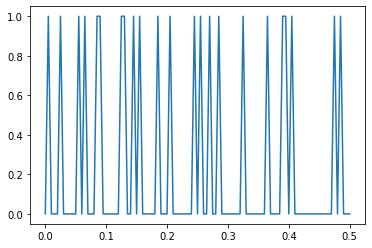

In [28]:
plt.plot(timex, testx)

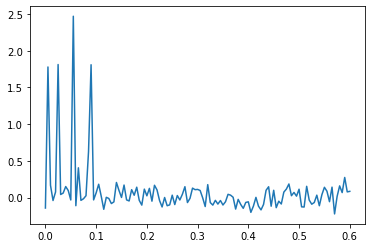

In [12]:
plt.plot(timey, testy)

## Function Definitions

### SE Prior


In [ ]:
@jit
def squared_exp2(I, J, Ell, Sigma_f):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2*Ell**2.0))

In [ ]:
vec_SE = jit(vmap(vmap(squared_exp2, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

In [ ]:
@jit
def root_squared_exp2(I, J, Ell, Sigma_f, Dt):
  return Sigma_f*(2/jnp.pi)**(0.25)*(Dt/Ell)**(0.5)*jnp.exp(-(I-J)**2/Ell**2)

In [ ]:
vec_SE_root = jit(vmap(vmap(root_squared_exp2, in_axes=[None,0,None,None, None]),in_axes=[0,None,None,None, None]))

### Variational Bound (ELBO)

#### KL Divergence

In [ ]:
@jit
def kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu):
  # Not including m/2 term as not being optimised over
  return jnp.sum(jnp.log(jnp.diag(L_matrix))) + 0.5*(jnp.linalg.norm(L_matrix)**2) + \
            0.5*(jnp.linalg.norm(jnp.linalg.lstsq(Prior_cov_root, Mu_prior)[0] - Param_vu)**2)

In [ ]:
jax.devices()

In [ ]:
jax.device_count()

1

#### Log Multivariate Gaussian PDF

In [ ]:
@jit
def logmultivariate_normal(Input, Mean, Covariance_Matrix):
  # Excluding the sqrt(2*pi)**k to avoid overflow
  Diff = Input-Mean
  return -0.5*((Diff.T@jnp.linalg.lstsq(Covariance_Matrix, Diff)[0]) + jnp.log(jnp.linalg.det(Covariance_Matrix)))

In [ ]:
#%timeit logmultivariate_normal(jnp.zeros((10000,)), jnp.zeros((10000,)), jnp.eye(10000))

In [ ]:
vec_lognorm = jit(vmap(logmultivariate_normal, in_axes = [0, None, None]))

In [ ]:
vec_lognorm(jnp.vstack((jnp.ones((10,)), jnp.zeros((10,)))), jnp.zeros((10,)), jnp.eye(10))

DeviceArray([-5., -0.], dtype=float32)

#### Expected Log Likelihood

In [ ]:
@jit
def Log_Likely(Sampled_f, Truex, Truey, Sigma_n):

  K = jnp.shape(Truex)[0] - 1
  M = jnp.shape(Truey)[0] - K -1
  
  # Pad input and filter
  X_pad = jnp.hstack((Truex, jnp.zeros((M,))))
  F_pad = jnp.hstack((Sampled_f, jnp.zeros((K,))))

  # Compute the FFTs
  X_fft = jnp.fft.fft(X_pad)
  F_fft = jnp.fft.fft(F_pad)

  # Elementwise multiplication
  FFTmul = jnp.multiply(X_fft, F_fft)

  # Make mean
  Y_mean = jnp.real(jnp.fft.ifft(FFTmul))

  return jsc.stats.multivariate_normal.logpdf(Truey, Y_mean, Sigma_n*jnp.eye(M+K+1))

In [ ]:
Log_Likely(jnp.ones((21,)), timex.flatten(), timey.flatten(), 0.05)

DeviceArray(-29424.24, dtype=float32)

In [ ]:
vec_loglikely = jit(vmap(Log_Likely, in_axes = [0, None, None, None]))

In [ ]:
@partial(jit, static_argnums=11)
def Exp_qf(Knn, Knm, Kmm, Inducing_Mean, Prior_cov_root, L_matrix, Num_Inducing, Subkey, Truex, Truey, Sigma_n, Number_f):

  # Sampling f
  A = Knm @ jnp.linalg.inv(Kmm)
  F_Mean = A @ Inducing_Mean
  F_Covariance = Knn + A @ (Prior_cov_root @ L_matrix @ L_matrix.T @ Prior_cov_root
                            - Kmm) @ A.T

   # Cholesky f covariance
  #Chol_pwr = choleskypwr(F_Covariance)
  #F_Cholesky = lax.cond(Chol_pwr.any(), jnp.linalg.cholesky(F_Covariance + 10**(-10+jnp.sum(Chol_pwr)*jnp.eye(Num_Inducing))), jnp.linalg.cholesky(F_Covariance))

  Sampled_f = random.multivariate_normal(Subkey, F_Mean, F_Covariance, shape = (Number_f,), method = 'svd')

  return jnp.mean(vec_loglikely(Sampled_f, Truex, Truey, Sigma_n), axis = None)

In [ ]:
induc_p = timex[::10]

In [ ]:
timef = timex[:21]

In [ ]:
exar = [Exp_qf(vec_SE(timef, timef, 0.05, 1.0), vec_SE(timef, induc_p, 0.05, 1.0), vec_SE(induc_p, induc_p, 0.05, 1.0), jnp.zeros((11,)), jnp.eye(11), jnp.eye(11), 11, subkeys[-1], timex.flatten(), timey.flatten(), 0.05, i) for i in np.arange(1, 300000, 10000)]

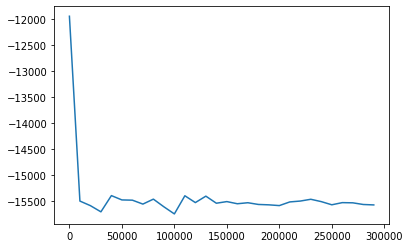

In [ ]:
plt.plot(np.arange(1, 300000, 10000), exar)

#### Cholesky Check

In [ ]:
@jit
def checknans(Symmetric_Matrix, Power):
  # Power MUST be input as a float
  M = jnp.shape(Symmetric_Matrix)[0]
  return Symmetric_Matrix, jnp.isnan(jnp.linalg.cholesky(Symmetric_Matrix +
                                                         (10**Power)*jnp.eye(M))).any().astype('f')

In [ ]:
@jit
def choleskypwr(Symmetric_Matrix):
  Number_check = 10
  Power_list = -1*jnp.arange(Number_check + 1, dtype='f')
  _, Failure = lax.scan(checknans, Symmetric_Matrix, Power_list)
  return Failure

In [ ]:
def choleskyit(Symmetric_Matrix):
  Number_check = 10
  Power_list = -1*jnp.arange(Number_check+1)
  Base_list = 10*jnp.ones(Number_check)
  Lambdas = jnp.power(Base_list, Power_list)
  M = jnp.shape(Symmetric_Matrix)[0]
  Larr = jnp.linalg.cholesky(Symmetric_Matrix).flatten()
  Ind = 1

  while jnp.isnan(Larr).any():
    Larr = jnp.linalg.cholesky(Symmetric_Matrix + Lambdas.at[-Ind].get()*jnp.eye(M)).flatten()
    Ind += 1

  return Larr.reshape((M, M))

#### ELBO

In [62]:
@partial(jit, static_argnums=3)
def ELBO(Number_f, Num_Inducing, Subkey, Inducing_Points, Param_vu, 
         L_matrix, Mu_prior, Ell, Sigma_f, Sigma_n, Truex, Truey, Dt, F_locs):
  Knn = vec_SE(F_locs, F_locs, Ell, Sigma_f)
  Knm = vec_SE(F_locs, Inducing_Points, Ell, Sigma_f)
  Kmm = vec_SE(Inducing_Points, Inducing_Points, Ell, Sigma_f)
  Prior_cov_root = vec_SE_root(Inducing_Points, Inducing_Points, Ell, Sigma_f, Dt)

  Inducing_Mean = Prior_cov_root @ Param_vu
  return Exp_qf(Knn, Knm, Kmm, Inducing_Mean, Prior_cov_root, L_matrix, Num_Inducing, Subkey, Truex, Truey, Sigma_n, Number_f) - \
            kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu)


### Make Lower Triangle from L

In [48]:
def L_fill(L_arr, Num_Inducing):
  L_mat = jnp.zeros((Num_Inducing, Num_Inducing))
  mask = jnp.tri(Num_Inducing, dtype=bool)
  L_mat = L_mat.at[mask].set(L_arr)
  return L_mat

### Gradient Ascent

In [ ]:
def grad_asc_MargL(Epsilon, Initial):
  """
    Initial a vector of:
       - Inducing Points (Initial[:m])
       - L Parameter (Initial[m:m+(m*(m+1)/2)])
       - Vu Parameter (Inital[m+(m*(m+1)/2):2*m+(m*(m+1)/2)])
       - Mu of Prior (Initial[2*m+(m*(m+1)/2): 3*m+(m*(m+1)/2)])
       - Ell of Prior (Initial[3*m+(m*(m+1)/2)])
       - Sigma_f of Prior (Initial[3*m+(m*(m+1)/2)+1])
       - Sigma_n of Prior/Model (Initial[3*m+(m*(m+1)/2)+2])
    
    Truex is the observed input data

    Truey is the observed output data

    F_locs is the timestamps of the filter trying to infer
  """
  Max_Inducing = 10000
  Max_OutV_Len = jnp.rint(0.5*(Max_Inducing**2+5*Max_Inducing))
  Output_Vector = jnp.zeros(0.5*(Max_OutV_Len))

  SizeIn = jnp.shape(Initial)[0]
  Number_Inducing = jnp.rint(0.5*(-5+jnp.sqrt(25+8*SizeIn)))
  Gradient = jnp.ones(SizeIn)
  CurrIn = Initial

  while jnp.linalg.norm(Gradient) > Epsilon:
    Current_ELBO = ELBO(CurrIn)
    Step = -Gradient(CurrIn)

In [ ]:
def Grad_Ascent(Inducing_Points, L_Arr, Vu_Init, Mu_Init, Ell_Init, Sigma_f_Init, 
                Sigma_n_Init, Truex, Truey, F_locs, Dt, Epsilon):
  """
    Initial with vectors of:
       - Inducing Points (Initial[:m])
       - L Parameter (Initial[m:m+(m*(m+1)/2)])
       - Vu Parameter (Inital[m+(m*(m+1)/2):2*m+(m*(m+1)/2)])
       - Mu of Prior (Initial[2*m+(m*(m+1)/2): 3*m+(m*(m+1)/2)])
       - Ell of Prior (Initial[2*m+(m*(m+1)/2)])
       - Sigma_f of Prior (Initial[2*m+(m*(m+1)/2)+1])
       - Sigma_n of Prior/Model (Initial[2*m+(m*(m+1)/2)+2])
    
    Truex is the observed input data

    Truey is the observed output data

    Dt is the time resolution

    F_locs is the timestamps of the filter trying to infer    
  """
  Curr_IP = Inducing_Points
  Curr_LA = L_Arr
  Curr_Vu = Vu_Init
  Curr_Mu = Mu_Init
  Curr_Ell = Ell_Init
  Curr_Sf = Sigma_f_Init
  Curr_Sn = Sigma_n_Init
  Num_Inducing =  jnp.shape(Inducing_Points)[0]

  while jnp.linalg.norm(Gradient_ELBO)>Epsilon:
    Curr_ELBO = ELBO()  







#### Data to test the functions individually

In [ ]:
# Generate random key
key = random.PRNGKey(0)
key, *subkeys = random.split(key, 4)
subkeyl = subkeys[0]
subkeysig = subkeys[1]

# Generated test inducing points
num_ind = 10
tstloc = random.truncated_normal(key, 0.0, timey[-1]-timex[-1], (num_ind,))
tstloc = jnp.sort(tstloc)

# Generate covariance of inducing points with SE function (for ease, shouldn't ...
# do this for actual thing)
l_param = random.uniform(subkeyl)
sigma_param = random.uniform(subkeysig)
Gmat = vec_SE(tstloc, tstloc, 0.05, 1.0)

chol_chek = choleskypwr(Gmat)

# Use cond statement to make more efficient
Lnew = jnp.linalg.cholesky(Gmat + chol_chek.any()*(10**(-10+jnp.sum(chol_chek)))*jnp.eye(num_ind))

# Generate arbitrary lower triangular matrix (not from PSD or symmetric)
tstmat = jnp.zeros((4,4))
tstmat = tstmat.at[jnp.tril_indices(4)].set(jnp.arange(1,11).astype('f'))

NameError: ignored

## Running Scripts

### Setting up initial conditions

In [50]:
num_inducing_points = 20
init_inducing_points = jnp.linspace(0.0, timey[-1]-timex[-1], num_inducing_points)
init_L = jnp.eye(num_inducing_points).at[jnp.tri(num_inducing_points, dtype=bool)].get()
init_vu = jnp.zeros(num_inducing_points)
init_mu = jnp.zeros(num_inducing_points)
init_l = 0.01
init_sigma_f = 2.0
init_sigma_n = 0.05

In [59]:
testx = testx.flatten()
testy = testy.flatten()
dt = timey[1] - timey[0]
f_loc = jnp.arange(0.0, timey[-1]-timex[-1]+dt, dt) 

In [60]:
print(f_loc)

[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
